## Challenge on unknown data


- check nans, remove or replace --> no nan, only float
- outcome categorical, balanced
- split into test train (X, y)
- z_score data

- train diff models


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection as skms
import sklearn.preprocessing as skpp
import xgboost as xgb

from sklearn.metrics import confusion_matrix, roc_curve,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC

plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
raw_data = pd.read_csv('/Users/iMotz/Propulsion/Machine_learning/data_sets/data_challange', sep = ';', index_col = 0)
raw_y = pd.read_csv('/Users/iMotz/Propulsion/Machine_learning/data_sets/target_challange', sep = ';', index_col = 0)

raw_data.describe(5)


,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
count,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,...,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000
mean,0.022051,19.985626,0.021562,-0.002995,0.006714,1.199634,-0.006762,0.280480,0.006097,0.484069,...,-0.008576,-0.021313,-0.001568,-0.003094,0.009283,0.000226,0.005910,-0.008889,0.014320,0.008260
std,0.991325,1.015550,1.003432,1.002988,0.997870,0.230327,0.999629,2.125397,1.005581,1.541105,...,1.002347,1.006412,0.983765,0.996446,1.004282,1.000520,1.016056,0.995702,1.013125,1.003070
min,-3.805191,16.521388,-3.813524,-3.782030,-3.674718,0.237787,-3.937798,-7.317683,-3.690032,-4.093185,...,-3.766574,-3.839330,-4.209261,-3.812813,-3.452933,-3.699101,-3.720500,-4.115588,-4.257204,-3.630376
25%,-0.654829,19.303917,-0.643915,-0.683303,-0.662130,1.037840,-0.673879,-1.091378,-0.656263,-0.635719,...,-0.684448,-0.698109,-0.660070,-0.679369,-0.688560,-0.671689,-0.672856,-0.685557,-0.662973,-0.677000
50%,0.030590,19.981310,0.030019,-0.003238,0.003731,1.189195,-0.006806,0.048849,0.006165,0.487916,...,0.009914,-0.015670,-0.004816,-0.013078,-0.001511,-0.006923,0.010327,-0.011907,0.023862,0.001320
75%,0.694404,20.669129,0.694731,0.678467,0.700963,1.357369,0.657758,1.435125,0.679482,1.561507,...,0.668117,0.658068,0.659073,0.689670,0.685061,0.672553,0.687531,0.642187,0.697549,0.685599
max,3.735828,24.018554,3.979113,4.057908,3.588100,1.974618,3.743804,9.802432,3.751348,6.595337,...,3.724825,3.364573,3.523111,3.489505,3.575871,4.320826,3.428363,4.199790,3.715033,4.532005


In [3]:
# check for balanced output
raw_y['0'].value_counts()

1.0    4763
0.0    4737
Name: 0, dtype: int64

In [17]:
raw_y = raw_y['0']

#### Explore feature correlation

In [4]:
# get correlations, binary/object will be disregarded 
raw_data_corr = raw_data.corr()
# get col names
feature_names = list(raw_data_corr)


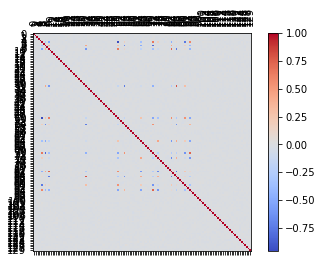

In [5]:
# plot heat map
plt.imshow(raw_data_corr, cmap = 'coolwarm') # interpolation = 'nearest'
plt.tick_params(labeltop = 1, labelbottom = 0)
plt.xticks(range(len(feature_names)), feature_names, rotation = 90)
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
None

### Construct Random Forest pipeline

In [26]:
# select steps for Random forest

pipe_1 = Pipeline([('scl', skpp.StandardScaler() ), # zscore
                   ('skb', SelectKBest(score_func = f_classif) ), # feature selection, ANOVA
                   ('randFor', RandomForestClassifier() ) ]) # model

# put all parameters in dictionary
grid_params_pipe_1 = {'skb__k': list(range(2,len(feature_names),2)),
                       'randFor__criterion': ['gini', 'entropy'],
                       'randFor__n_estimators': list(range(100, 240, 20)),
                       'randFor__min_samples_leaf': [2,3,4,5,6],
                       'randFor__max_depth': list(range(2, 14, 2)),
                       'randFor__min_samples_split': [2,3,4,5,6] }


#### Random Search

In [28]:
# fit models ! ACHTUNG TIME !
myRS = skms.RandomizedSearchCV(estimator = pipe_1, param_distributions = grid_params_pipe_1, 
                               scoring = 'accuracy', cv = 3, n_iter = 20,
                               n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

In [31]:
# print results
print('Best accuracy random search: %.3f' % myRS.best_score_)
print('\nBest params:\n', myRS.best_params_)

Best accuracy: 0.933

Best params:
 {'skb__k': 26, 'randFor__n_estimators': 120, 'randFor__min_samples_split': 2, 'randFor__min_samples_leaf': 4, 'randFor__max_depth': 10, 'randFor__criterion': 'entropy'}


In [35]:
# put better parameters in dictionary
grid_params_pipe_1_better = {'skb__k': [24,26,28],
                       'randFor__criterion': ['entropy'],
                       'randFor__n_estimators': [120],
                       'randFor__min_samples_leaf': [3,4,5],
                       'randFor__max_depth': [9,10,11],
                       'randFor__min_samples_split': [2,3,4] }

#### Grid Search

In [36]:
# fit models ! ACHTUNG TIME !
myGS = skms.GridSearchCV(estimator = pipe_1, param_distributions = grid_params_pipe_1_better, 
                               scoring = 'accuracy', cv = 3,
                               n_jobs = -1, verbose = 1).fit(raw_data, raw_y)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.7min finished


In [62]:
# print results
print('Best accuracy: %.3f' % myGS.best_score_)
print('\nBest params:\n', myGS.best_params_)

Best accuracy: 0.934

Best params:
 {'randFor__criterion': 'entropy', 'randFor__max_depth': 11, 'randFor__min_samples_leaf': 3, 'randFor__min_samples_split': 4, 'randFor__n_estimators': 120, 'skb__k': 26}


#### check if overfitted: 

In [63]:
# check if overfitted: predict TRAIN set, score should not be much higher than best_score_ of model!
predicted_y = myGS.predict(raw_data)
accuracy_score(predicted_y, raw_y)


0.9546315789473684

### Construct XGBoost pipeline

In [71]:
pipe_2 = Pipeline([('scl', skpp.StandardScaler() ), # zscore
                   ('skb', SelectKBest(score_func = f_classif) ), # feature selection, ANOVA
                   ('xgb', xgb.XGBClassifier(objective='binary:logistic')) ]) # model

# put all parameters in dictionary
grid_params_pipe_2 = {'skb__k': list(range(2,len(feature_names),4)),
                       'xgb__n_estimators': list(range(100, 200, 20)),
                       'xgb__max_depth': list(range(2, 10, 2)), # ~6, higher val will overfit
                       'xgb__subsample': [0.3,0.4,0.5,0.6,0.7,0.8],
                       'xgb__lambda': [0.001, 0.1,0.5,1], # prevents overfitting
                       'xgb__rate_drop': [0.5, 0.8, 1] } # prevents overfitting
                 

#### Random Search

In [72]:
# Random Search fit models ! ACHTUNG TIME !
myXGB_RS = skms.RandomizedSearchCV(estimator = pipe_2, param_distributions = grid_params_pipe_2, 
                               scoring = 'accuracy', cv = 3, n_iter = 20,
                               n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


In [74]:
# print results
print('Best accuracy: %.3f' % myXGB_RS.best_score_)
print('\nBest params:\n', myXGB_RS.best_params_)

Best accuracy: 0.940

Best params:
 {'xgb__subsample': 0.8, 'xgb__rate_drop': 0.5, 'xgb__n_estimators': 120, 'xgb__max_depth': 8, 'xgb__lambda': 0.1, 'skb__k': 122}


In [79]:
# put better parameters in dictionary
grid_params_pipe_2_better = {'skb__k': [120,125,130],
                       'xgb__n_estimators': [105,110,115],
                       'xgb__max_depth': [6,7], # ~6, higher val will overfit
                       'xgb__subsample': [0.8],
                       'xgb__lambda': [0.1], # prevents overfitting
                       'xgb__rate_drop': [0.5] } # prevents overfitting

#### Grid Search

In [80]:
# GRID Search fit models ! ACHTUNG TIME !
myXGB_GS = skms.GridSearchCV(estimator = pipe_2, param_grid = grid_params_pipe_2_better,
                         scoring = 'accuracy',  cv = 5,
                         n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.6min finished


In [81]:
# print results
print('Best accuracy: %.3f' % myXGB_GS.best_score_)
print('\nBest params:\n', myXGB_GS.best_params_)

Best accuracy: 0.943

Best params:
 {'skb__k': 130, 'xgb__lambda': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 110, 'xgb__rate_drop': 0.5, 'xgb__subsample': 0.8}


#### check if overfitted:

In [82]:
# predict TRAIN set, score should not be much higher than best_score_ of model!
predicted_y = myXGB_GS.predict(raw_data)
accuracy_score(predicted_y, raw_y)


0.999578947368421

### Construct AdaBoost pipeline

In [44]:
pipe_3 = Pipeline([('scl', skpp.StandardScaler() ), # zscore
                   ('skb', SelectKBest(score_func = f_classif) ), # feature selection, ANOVA
                   ('ada', AdaBoostClassifier()) ]) # model

# put all parameters in dictionary
grid_params_pipe_3 = {'skb__k': list(range(2,len(feature_names),4)),
                       'ada__n_estimators': list(range(40, 200, 20)),
                       'ada__learning_rate': [0.01, 0.05, 0.5, 1] }

#### Random search

In [45]:
# Random Search fit models ! ACHTUNG TIME !
myAda_RS = skms.RandomizedSearchCV(estimator = pipe_3, param_distributions = grid_params_pipe_3, 
                               scoring = 'accuracy', cv = 3, n_iter = 20,
                               n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


In [46]:
# print results
print('Best accuracy: %.3f' % myAda_RS.best_score_)
print('\nBest params:\n', myAda_RS.best_params_)

Best accuracy: 0.919

Best params:
 {'skb__k': 90, 'ada__n_estimators': 180, 'ada__learning_rate': 0.5}


In [54]:
# put better parameters in dictionary
grid_params_pipe_3_better = {'skb__k': [90,100,110],
                       'ada__n_estimators': [190, 200, 210],
                       'ada__learning_rate': [0.4,0.45, 0.5] }

#### Grid search

In [55]:
# GRID Search fit models ! ACHTUNG TIME !
myAda_GS = skms.GridSearchCV(estimator = pipe_3, param_grid = grid_params_pipe_3_better,
                         scoring = 'accuracy',  cv = 3,
                         n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  4.4min finished


In [57]:
# print results
print('Best accuracy: %.3f' % myAda_GS.best_score_)
print('\nBest params:\n', myAda_GS.best_params_)

Best accuracy: 0.921

Best params:
 {'ada__learning_rate': 0.4, 'ada__n_estimators': 200, 'skb__k': 100}


#### check if overfitted: 

In [58]:
# predict TRAIN set, score should not be much higher than best_score_ of model!
predicted_y = myAda_GS.predict(raw_data)
accuracy_score(predicted_y, raw_y)


0.9278947368421052

### Construct SVM pipeline

In [96]:
pipe_4 = Pipeline([('scl', skpp.StandardScaler() ), # zscore
                   ('skb', SelectKBest(score_func = f_classif) ), # feature selection, ANOVA
                   ('svm', SVC(degree = 3,gamma = 'auto')) ]) # model

# put all parameters in dictionary
grid_params_pipe_4 = {'skb__k': list(range(2,len(feature_names),4)),
                      'svm__C': [0.001, 0.005, 0.01, 0.5, 1.0, 5,  10],
                      'svm__kernel': ['linear', 'poly', 'rbf']}      

#### Random Search

In [97]:
# Random Search fit models ! ACHTUNG TIME !
mySVM_RS = skms.RandomizedSearchCV(estimator = pipe_4, param_distributions = grid_params_pipe_4, 
                               scoring = 'accuracy', cv = 3, n_iter = 20,
                               n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


In [98]:
# print results
print('Best accuracy: %.3f' % mySVM_RS.best_score_)
print('\nBest params:\n', mySVM_RS.best_params_)

Best accuracy: 0.928

Best params:
 {'svm__kernel': 'rbf', 'svm__C': 1.0, 'skb__k': 34}


In [109]:
# put better parameters in dictionary
grid_params_pipe_4_better = {'skb__k': list(range(18,36,2)),
                      'svm__C': [0.8, 1.0, 1.5, 2.0],
                      'svm__kernel': ['rbf']}  

#### Grid search

In [111]:
# GRID Search fit models ! ACHTUNG TIME !
mySVM_GS = skms.GridSearchCV(estimator = pipe_4, param_grid = grid_params_pipe_4_better,
                         scoring = 'accuracy',  cv = 6,
                         n_jobs = -1, verbose = 1).fit(raw_data, raw_y)

Fitting 6 folds for each of 36 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.2min finished


In [112]:
# print results
print('Best accuracy: %.3f' % mySVM_GS.best_score_)
print('\nBest params:\n', mySVM_GS.best_params_)

Best accuracy: 0.941

Best params:
 {'skb__k': 18, 'svm__C': 2.0, 'svm__kernel': 'rbf'}


#### check if overfit

In [115]:
# predict TRAIN set, score should not be much higher than best_score_ of model!
predicted_y = mySVM_GS.predict(raw_data)
accuracy_score(raw_y,predicted_y)

0.9486315789473684

### Final prediction

In [114]:
# plot final scores

scores_df = pd.DataFrame({'Random Forest': [myGS.best_score_], 'XGBoost':[myXGB_GS.best_score_],
                          'AdaBoost': [myAda_GS.best_score_], 'SVM': [mySVM_GS.best_score_] })

scores_df


,Random Forest,XGBoost,AdaBoost,SVM
0,0.934,0.942526,0.920842,0.941158


In [ ]:
# Save best grid search pipeline to file
dump_file = 'Doris_best_model.pkl'
joblib.dump(myXGB_GS, dump_file, compress=1)

In [117]:
# X_test for prediction:
X_test = pd.read_csv('/Users/iMotz/Propulsion/Machine_learning/data_sets/data_validation.csv', sep = ';', index_col = 0)
X_test.head(5)


,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
9500,-1.899341,19.987847,0.284238,0.911944,-0.300063,1.394787,-0.270603,-2.541618,-0.185893,-1.414367,...,-0.089265,-0.551510,1.372204,0.270275,-0.502945,1.467500,-0.076148,-0.409534,-0.366622,0.131223
9501,0.520471,20.159611,-0.485186,0.221774,1.161836,1.302956,0.684482,-0.329793,1.351988,-0.906142,...,-0.064659,0.338590,-0.109461,0.414044,0.238316,0.588103,-0.138387,-0.849629,0.926753,0.884482
9502,-0.809059,19.099730,1.249379,-0.620310,-0.420566,0.867080,-2.609620,5.859913,-0.629947,3.865656,...,0.788851,0.944825,0.265963,1.888080,-0.249806,0.969314,1.507961,-0.205873,-0.046881,-0.412780
9503,0.165187,20.248089,-1.114634,-0.171681,2.122901,1.165624,-1.379544,1.237258,-0.059088,1.206346,...,0.094780,0.862895,-0.251012,1.261560,-2.008086,0.778200,1.480746,0.474627,0.653869,0.457816
9504,-0.516325,20.796151,-0.135054,-0.465882,-0.151519,0.959848,-1.278178,0.588861,-1.146469,2.451967,...,1.273680,-0.037221,-1.364685,-0.307275,0.167634,-0.641041,-1.181750,2.515981,0.570686,-0.581697


In [121]:
y_predicted = mySVM_GS.predict(X_test)
y_predicted

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 1.

In [120]:

np.savetxt('/Users/iMotz/Propulsion/Machine_learning/data_sets/DorisAlbin_result.csv', y_predicted, delimiter=',')
